In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<div id="toc"></div>

# N-N sum and background subtraction

P. Schuster  
University of Michigan  
January 2018  

Goal: Calculate the number of events in a specific time or energy range in the $nn$ cloud on the bicorrelation distribution. 

Start by loading some data. I will use the data from the combined data sets from Cf072115-Cf072215b.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import scipy.io as sio
import sys
import pandas as pd
from tqdm import *

# Plot entire array
np.set_printoptions(threshold=np.nan)

In [2]:
import seaborn as sns
sns.set_palette('spectral')
sns.set_style(style='white')

In [19]:
sys.path.append('../scripts/')
import bicorr as bicorr
import bicorr_plot as bicorr_plot

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
det_df = bicorr.load_det_df()

# $nn$ background subtraction

## Build two `bicorr_hist_master` versions

* One in the positive time range from 0 to 200 ns, `bhm_pos`
* One in the negative time range form -200 to 0 ns, `bhm_neg`

This is built into the default flux data processing script in `bicorr.py` as follows:

    print('********* Build bhm: Positive time range **********')
    build_bhm(folder_start,folder_end,dt_bin_edges = np.arange(0.0,200.25,0.25))
    print('********* Build bhm: Negative time range **********')
    build_bhm(folder_start,folder_end,dt_bin_edges = np.arange(-200.0,0.25,0.25),sparse_filename = 'sparse_bhm_neg')
    
Here I will load those arrays and perform the background subtraction, then generalize the technique in a new function. I will coarsen the time binning from 0.25 ns spacing to 2.5 ns spacing for both arrays.

In [7]:
sparse_bhm_pos, dt_bin_edges_pos = bicorr.load_sparse_bhm(filepath = r'../analysis/Cf072115_to_Cf072215b/datap/')[0:2]

In [8]:
bhm_pos = bicorr.revive_sparse_bhm(sparse_bhm_pos, det_df, dt_bin_edges_pos)

In [8]:
print('ORIGINAL ARRAYS')
print(bhm_pos.shape)
print(dt_bin_edges_pos.shape)
print(dt_bin_edges_pos[-10:])

ORIGINAL ARRAYS
(990, 4, 800, 800)
(801,)
[ 197.75  198.    198.25  198.5   198.75  199.    199.25  199.5   199.75
  200.  ]


In [9]:
bhm_pos, dt_bin_edges_pos = bicorr.coarsen_bhm(bhm_pos, dt_bin_edges_pos, 4)

In [10]:
print('COARSE ARRAYS')
print(bhm_pos.shape)
print(dt_bin_edges_pos.shape)
print(dt_bin_edges_pos[-10:])

COARSE ARRAYS
(990, 4, 200, 200)
(201,)
[ 191.  192.  193.  194.  195.  196.  197.  198.  199.  200.]


In [12]:
sparse_bhm_neg, dt_bin_edges_neg = bicorr.load_sparse_bhm(filepath = r'../analysis/Cf072115_to_Cf072215b/datap/',filename='sparse_bhm_neg.npz')[0:2]

In [13]:
bhm_neg = bicorr.revive_sparse_bhm(sparse_bhm_neg, det_df, dt_bin_edges_neg)

In [14]:
bhm_neg, dt_bin_edges_neg = bicorr.coarsen_bhm(bhm_neg, dt_bin_edges_neg, 4)

## Store `bhp` for $nn$ interactions

In [15]:
bhp_nn_pos = bicorr.build_bhp(bhm_pos,dt_bin_edges_pos,type_is=[0])[0]
bhp_nn_neg = bicorr.build_bhp(bhm_neg,dt_bin_edges_neg,type_is=[0])[0]

Take a quick look at plots:

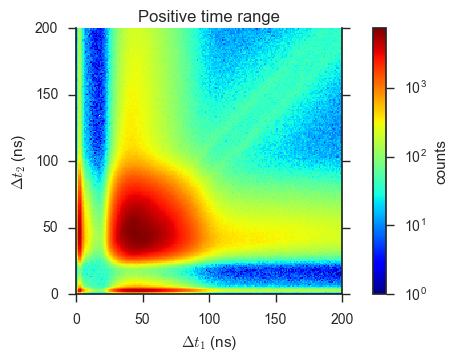

In [20]:
bicorr_plot.bhp_plot(bhp_nn_pos,dt_bin_edges_pos,title='Positive time range',show_flag=True)

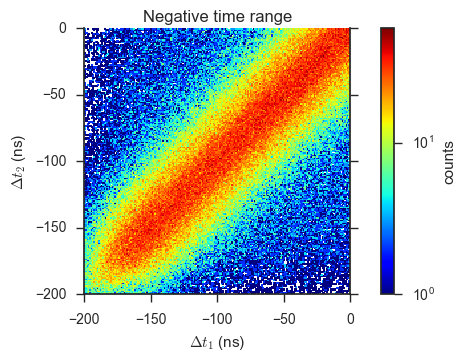

In [21]:
bicorr_plot.bhp_plot(bhp_nn_neg,dt_bin_edges_neg,title='Negative time range',show_flag=True)

## Translate negative data to positive time range

I need to flip the data around. What is the most pythonic way of accomplishing this?

I'm going to start with a test array to make sure I have the correct method. 

In [33]:
x = np.arange(-10,1,1)
y = x.T

test_array_neg = np.zeros([10,10])
test_array_neg[0,0] = 3
test_array_neg[2,9] = 6
test_array_neg[9,5] = 10

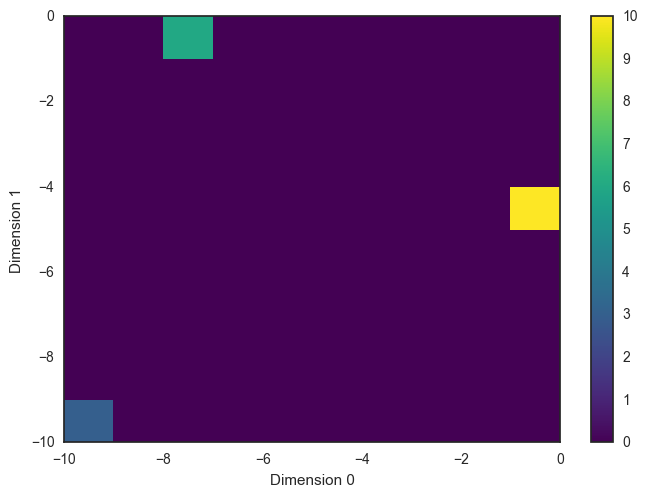

In [41]:
x = dt_test_neg
y = dt_test_neg.T
plt.pcolormesh(x,y,test_array_neg.T,cmap='viridis')
plt.xlabel('Dimension 0')
plt.ylabel('Dimension 1')
plt.colorbar()
plt.show()

Flip the array. The result should look as follows:
* The x and y axes should go from 0 to +10
* Blue box in upper right
* Yellow box on left edge
* Green box on lower edge near right

In [37]:
dt_test_pos = np.arange(0,11,1)
test_array_pos = test_array_neg[::-1,::-1]

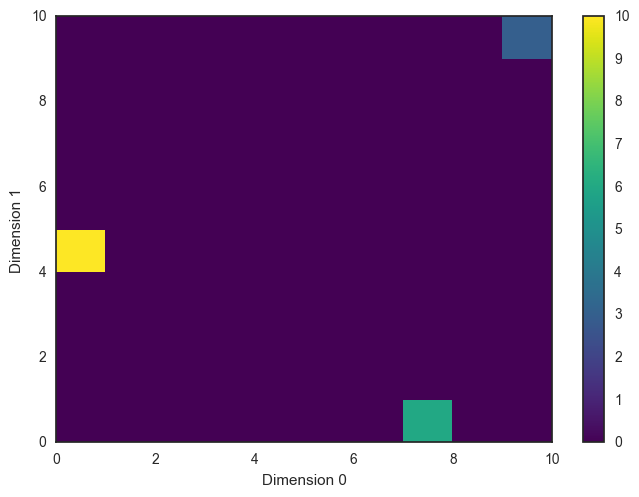

In [42]:
plt.pcolormesh(dt_test_pos,dt_test_pos,test_array_pos.T,cmap="viridis")
plt.xlabel('Dimension 0')
plt.ylabel('Dimension 1')
plt.colorbar()
plt.show()

Try it for a smaller size.

In [52]:
x = np.arange(-3,1,1)
y = x.T

test_array_neg = np.zeros([3,3])
test_array_neg[1,1] = 6
test_array_neg[2,2] = 1
test_array_neg[2,0] = 12
test_array_pos = test_array_neg[::-1,::-1]

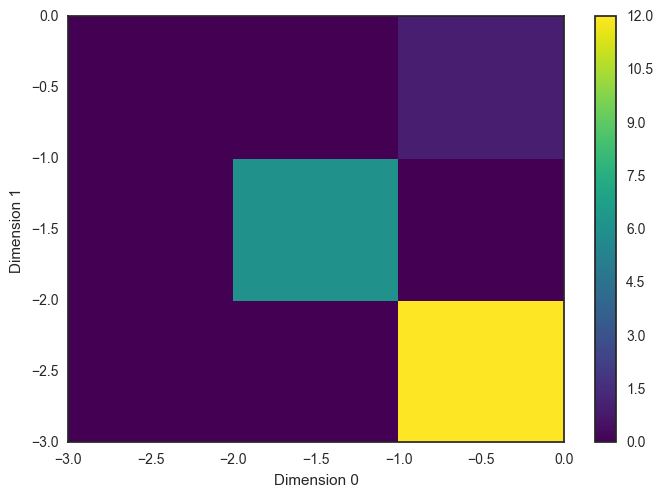

In [53]:
plt.pcolormesh(x,y,test_array_neg.T,cmap='viridis')
plt.xlabel('Dimension 0')
plt.ylabel('Dimension 1')
plt.colorbar()
plt.show()

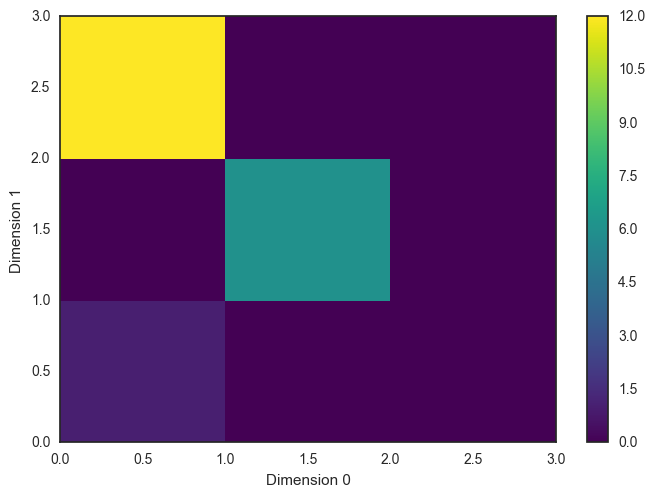

In [56]:
plt.pcolormesh(x,y,test_array_pos.T,cmap='viridis')
plt.xlabel('Dimension 0')
plt.ylabel('Dimension 1')
plt.colorbar()
plt.show()

In [59]:
tens = 10*np.ones([3,3])
print(tens)

[[ 10.  10.  10.]
 [ 10.  10.  10.]
 [ 10.  10.  10.]]


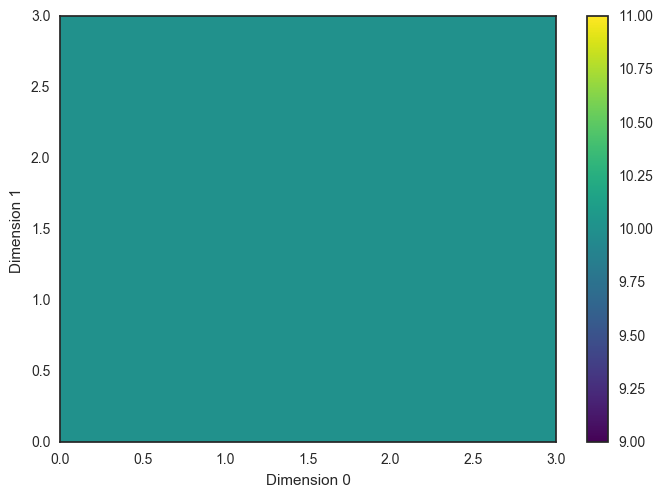

In [60]:
plt.pcolormesh(x,y,tens.T,cmap='viridis')
plt.xlabel('Dimension 0')
plt.ylabel('Dimension 1')
plt.colorbar()
plt.show()

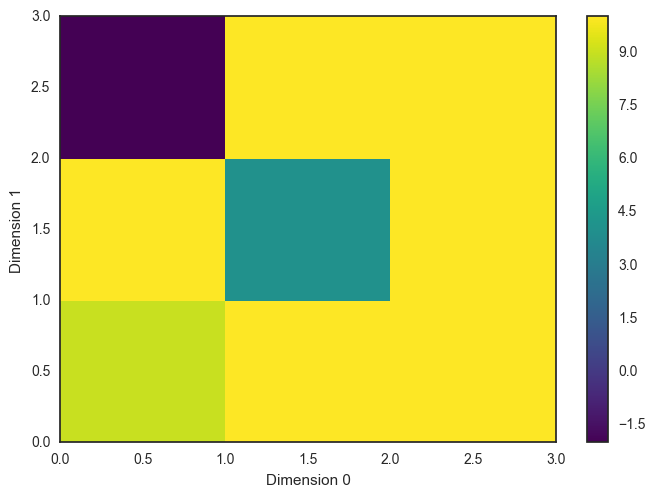

In [61]:
plt.pcolormesh(x,y,tens.T-test_array_pos.T,cmap='viridis')
plt.xlabel('Dimension 0')
plt.ylabel('Dimension 1')
plt.colorbar()
plt.show()

This subtraction looks good. Now back to the data. 

Do this now for the negative time range.

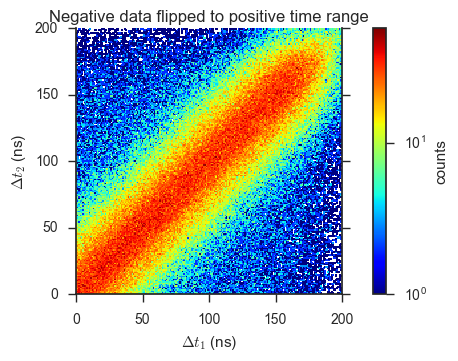

In [22]:
bicorr_plot.bhp_plot(bhp_nn_neg[::-1,::-1],dt_bin_edges_pos,title='Negative data flipped to positive time range',show_flag=True)

Look more closely at a corner, positive and negative.

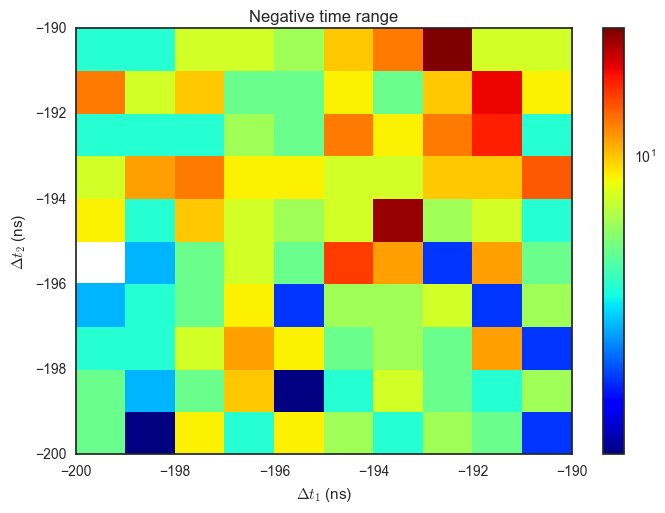

In [25]:
bicorr_plot.bhp_plot(bhp_nn_neg[:10,:10],dt_bin_edges_neg[:11],title='Negative time range',show_flag=True)

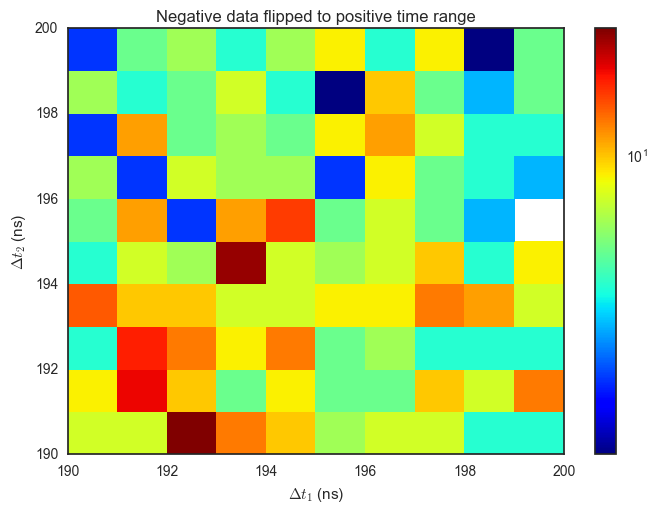

In [24]:
bicorr_plot.bhp_plot(bhp_nn_neg[::-1,::-1][-10:,-10:],dt_bin_edges_pos[-11:],title='Negative data flipped to positive time range',show_flag=True)

It looks like the flipping is happening correctly. So continue on. 

## Subtract negative flipped from positive

At this point, the data is stored as unsigned floats, but I will encounter instances where the background-subtracted counts are negative, so I need to convert the datatype to floats.

In [23]:
bhp_nn_diff = np.subtract(bhp_nn_pos.astype(np.int32),bhp_nn_neg[::-1,::-1].astype(np.int32))
bhp_nn_diff.shape

(200, 200)

In [24]:
bhp_nn_diff.dtype

dtype('int32')

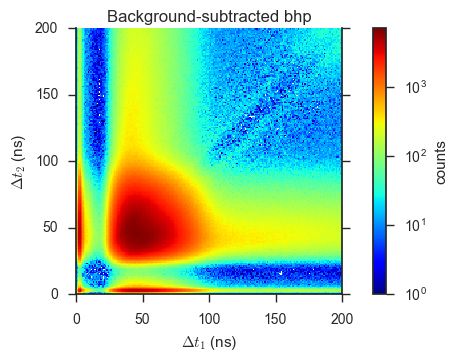

In [26]:
bicorr_plot.bhp_plot(bhp_nn_diff,dt_bin_edges_pos,title='Background-subtracted bhp',show_flag=True)

This looks great. I have to keep the positive and negative matrices for error propagation when I calculate the $nn$ count rate sum.

# Calculate $nn$ sum

I want to provide energy or timing windows as input parameters and calculate the number of events in that range. I will have to provide a normalization factor in case I have already performed the normalization. 

Question... should I go from the `bhm` or `bhp`? `bhm` is in terms of the number of counts, while `bhp` may already be normalized.

I think I should work from `bhp` and provide norm_factor as an optional input parameter. It is returned from `build_bhp` so I will have to store it. 

## Convert energy to time

Following Matthew's code...

In [28]:
emin = 0.62
emax = 12

tmin = bicorr.convert_energy_to_time(emax)
tmax = bicorr.convert_energy_to_time(emin)

print(tmin,tmax)

20.9260185521 92.0622074865


## Find the corresponding time bins

In [29]:
dt_bin_edges_pos

array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,
        117.,  118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,
        126.,  127.,

In [30]:
i_min = np.min(np.argwhere(tmin<dt_bin_edges_pos))
i_max = np.min(np.argwhere(tmax<dt_bin_edges_pos))

print(i_min,i_max)

21 93


In [31]:
dt_bin_edges_pos[i_min:i_max]

array([ 21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
        32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,
        87.,  88.,  89.,  90.,  91.,  92.])

In [32]:
np.sum(bhp_nn_pos[i_min:i_max,i_min:i_max])

12113048.0

Functionalized to `bicorr.calc_nn_sum`.

In [33]:
bicorr.calc_nn_sum(bhp_nn_pos, dt_bin_edges_pos)

12113048.0

## Calculate absolute sums for pos, neg, and diff regions

Look at the algebra for this. 

I have measured the following:

* Number of positive counts, $C_P$
* Number of negative counts, $C_N$
* Number of br-subtracted counts $C_D = C_P-C_N$ (diff)
* norm_factor

In [34]:
Cp = bicorr.calc_nn_sum(bhp_nn_pos, dt_bin_edges_pos)
Cn = bicorr.calc_nn_sum(bhp_nn_neg[::-1,::-1], dt_bin_edges_pos)
Cd = Cp-Cn
print('BR subtraction removes ', Cn/Cp*100, ' % of counts')

BR subtraction removes  0.960905958599  % of counts


The background subtraction makes about a 1% correction.

The errors in the counts follow counting statistics:

* $\sigma_{C_P} = \sqrt{C_P}$
* $\sigma_{C_N} = \sqrt{C_N}$
* $\sigma_{C_D} = \sqrt{C_D} = \sqrt{\sigma_{C_P}^2 + \sigma_{C_N}^2} = \sqrt{C_P + C_N}$

In [35]:
err_Cd = np.sqrt(Cp + Cn)
print('BR subtracted counts = ',Cd,' +/- ',err_Cd)

BR subtracted counts =  11996653.0  +/-  3497.06205264


In [36]:
print('Relative error = ', err_Cd/Cd)

Relative error =  0.000291503142805


## Calculate normalized sums for pos, neg, and diff regions


The `bicorr_hist_master` is not normalized, but when I calculate `bhp` with a `norm_factor` then it is normalized, so I am actually working with the following:

* Normalized number of positive counts, $N_P = C_P/F$
* Normalized number of negative counts, $N_N = C_N/F$
* Normalized number of br-subtracted counts, $N_D = C_D/F$
* where $F$ is the normalization factor

Create new `bhp` arrays that are normalized.

In [37]:
num_fissions = 2194651200.00

In [38]:
bhp_nn_pos, norm_factor = bicorr.build_bhp(bhm_pos,dt_bin_edges_pos,type_is=[0], num_fissions = num_fissions)
bhp_nn_neg              = bicorr.build_bhp(bhm_neg,dt_bin_edges_neg,type_is=[0], num_fissions = num_fissions)[0]

Assuming there is no uncertainty in $F$, the errors in the relative counts are:

* $\sigma_{N_P} = \sigma_{C_P}/F = \sqrt{C_P}/F$
* $\sigma_{N_N} = \sigma_{C_N}/F = \sqrt{C_N}/F$
* $\sigma_{N_D} = \sigma_{C_D}/F = \sqrt{C_P+C_N}/F$

In [39]:
Np = bicorr.calc_nn_sum(bhp_nn_pos,dt_bin_edges_pos)
Nn = bicorr.calc_nn_sum(bhp_nn_neg[::-1,::-1],dt_bin_edges_pos)
Nd = Np-Nn

In [40]:
print('BR subtraction removes ', Nn/Np*100, ' % of counts')

BR subtraction removes  0.960905958599  % of counts


In [41]:
err_Np = np.sqrt(Np/norm_factor)
err_Nn = np.sqrt(Nn/norm_factor)
err_Nd = np.sqrt((Np+Nn)/norm_factor)

In [42]:
print('The BR_subtracted counts is ',Nd,' +/- ',err_Nd)

The BR_subtracted counts is  5.52152948639e-06  +/-  1.60954319837e-09


In [43]:
print('Relative error = ', err_Nd/Nd)

Relative error =  0.000291503142805


# Functionalize `calc_nn_sum_br`

Functionalize a method for calculating the number of counts after background subtraction.

Run it to confirm function matches previous calculations. Run commands above to produce the correct `bhp`.

Absolute counts:

In [53]:
bhp_nn_pos = bicorr.build_bhp(bhm_pos,dt_bin_edges_pos,type_is=[0])[0]
bhp_nn_neg = bicorr.build_bhp(bhm_neg,dt_bin_edges_neg,type_is=[0])[0]

In [56]:
Cp, Cn, Cd, Cd_err = bicorr.calc_nn_sum_br(bhp_nn_pos,bhp_nn_neg,dt_bin_edges_pos)
print(Cp, Cn, Cd, Cd_err)

12113048.0 116395.0 11996653.0 3497.06205264


Relative counts:

In [57]:
bhp_nn_pos = bicorr.build_bhp(bhm_pos,dt_bin_edges_pos,type_is=[0], num_fissions = num_fissions)[0]
bhp_nn_neg = bicorr.build_bhp(bhm_neg,dt_bin_edges_neg,type_is=[0], num_fissions = num_fissions)[0]

In [58]:
Np, Nn, Nd, err_Nd = bicorr.calc_nn_sum_br(bhp_nn_pos,bhp_nn_neg,dt_bin_edges_pos,norm_factor=norm_factor)
print(Np, Nn, Nd, err_Nd)

5.57510096374e-06 5.35714773585e-08 5.52152948639e-06 1.60954319837e-09


# Calculate for all detector pairs

In the previous examples, I produced `bhp` for all pairs together. Now I will loop through each pair separately and calculate the sum. Work with absolute counts.

First create positive and negative `bhp` for all pairs.

In [67]:
bhp_nn_pos = np.zeros((len(det_df),len(dt_bin_edges_pos)-1,len(dt_bin_edges_pos)-1))
bhp_nn_neg = np.zeros((len(det_df),len(dt_bin_edges_neg)-1,len(dt_bin_edges_neg)-1))

In [69]:
for index in det_df.index.values: # index is same as in `bhm`
    bhp_nn_pos[index,:,:] = bicorr.build_bhp(bhm_pos,dt_bin_edges_pos,type_is=[0],pair_is=[index])[0]
    bhp_nn_neg[index,:,:] = bicorr.build_bhp(bhm_neg,dt_bin_edges_neg,type_is=[0],pair_is=[index])[0]

Save these to file for future use. 

I will call the files `bhp_nn_all_pairs_1ns.npz`. I have already saved something similar: `bhp_nn_by_pair_1ns.npz`, but that one has already cut out the fission chamber neighbors. I'll leave it in for this one. 

I want to save:
* bhp_nn_pos
* bhp_nn_neg
* dt_bin_edges_pos
* num_fissions
* note: 'Calculated in methods/nn_sum_and_br_subtraction, all pairs included'

In [74]:
os.listdir('../analysis/Cf072115_to_Cf072215b/datap/')

'C:\\Users\\pfschus\\Box Sync\\Projects\\fnpc\\methods'

In [75]:
np.savez('../analysis/Cf072115_to_Cf072215b/datap/bhp_nn_all_pairs_1ns',
         bhp_nn_pos = bhp_nn_pos,
         bhp_nn_neg = bhp_nn_neg,
         dt_bin_edges_pos = dt_bin_edges_pos)

In [72]:
whos

Variable                 Type         Data/Info
-----------------------------------------------
Cd                       float64      11996653.0
Cd_err                   float64      3497.06205264
Cn                       float64      116395.0
Cp                       float64      12113048.0
Nd                       float64      5.52152948639e-06
Nn                       float64      5.35714773585e-08
Np                       float64      5.57510096374e-06
TqdmDeprecationWarning   type         <class 'tqdm._tqdm.TqdmDeprecationWarning'>
TqdmKeyError             type         <class 'tqdm._tqdm.TqdmKeyError'>
TqdmTypeError            type         <class 'tqdm._tqdm.TqdmTypeError'>
bhm_neg                  ndarray      990x4x200x200: 158400000 elems, type `float64`, 1267200000 bytes (1208.49609375 Mb)
bhm_pos                  ndarray      990x4x200x200: 158400000 elems, type `float64`, 1267200000 bytes (1208.49609375 Mb)
bhp_nn_diff              ndarray      200x200: 40000 elems, type `in

Save these to file for future use. 
Then, calculate sums for each pair by looping back through bhp
Then store sums to a dataframe
Save dataframe to file with emin, max?
Make it easy to calculate sums and fill dataframe for new emin, emax values so that I can calculate anisotropy vs. Ethresh.